In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
from scipy.optimize import brute
from skopt import gp_minimize
import skopt.plots as skplt

In [24]:
# Read in data and clean it

data2013 = pd.read_csv('2013_Events.csv')
data2012 = pd.read_csv('2012_Events.csv')
data2011 = pd.read_csv('2011_Events.csv')
data20092010 = pd.read_csv('2009_2010_Events.csv')

data2013 = data2013[['Event start date', 'Number of protesters', 'Location']]
data2012 = data2012[['Event start date', 'Number of protesters', 'Location']]
data2011 = data2011[['Event start date', 'Number of protesters', 'Location']]
data20092010 = data20092010[['Event date', '# protester', 'Location']]
data20092010.columns = ['Event start date', 'Number of protesters', 'Location']

# Combine multiple years into one dataframe
data = pd.concat([data2013, data2012, data2011, data20092010])

# Sort by event date (descending)
data['Event start date'] = pd.to_datetime(data['Event start date'])
data = data.sort_values(by = 'Event start date')

data['Number of events'] = 0
data['Number of protesters'] = pd.to_numeric(data['Number of protesters'], errors='coerce')

data = data.groupby(data['Event start date']).aggregate({'Number of events': 'size', 'Number of protesters': 'sum'})

In [25]:
data.tail()

,Number of events,Number of protesters
Event start date,,
2013-12-27,20,405.0
2013-12-28,28,976.0
2013-12-29,42,7895.0
2013-12-30,26,543.0
2013-12-31,16,205.0


Text(0.5, 1.0, 'Protest Events in Ukraine')

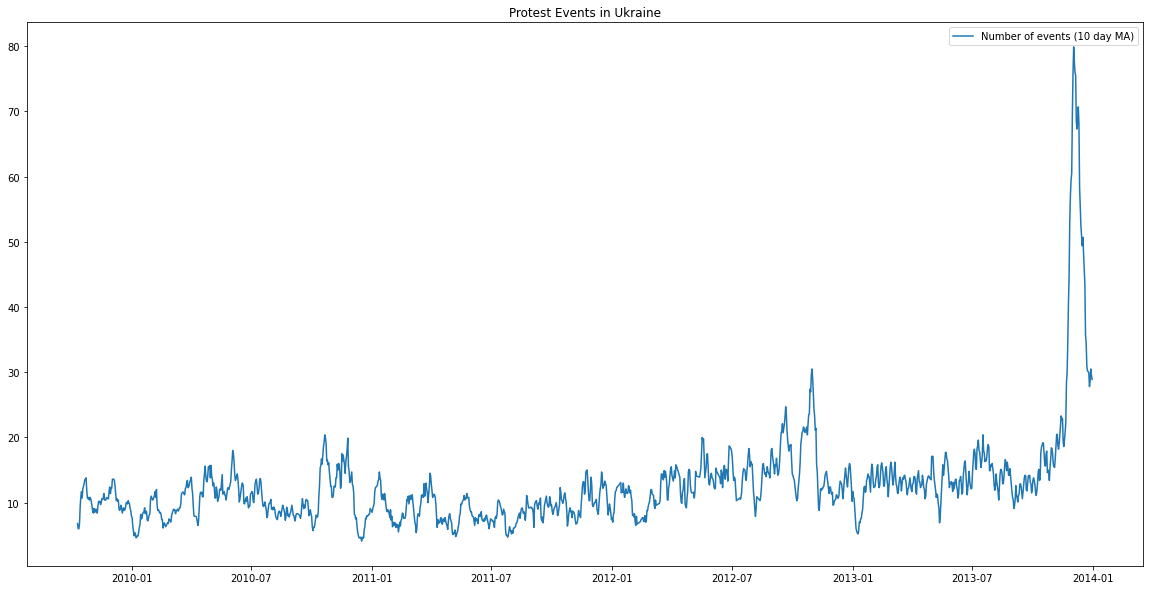

In [26]:
plt.figure(figsize=(20,10))
plt.plot(data['Number of events'].rolling(10).mean(), label='Number of events (10 day MA)')
plt.legend()
plt.title('Protest Events in Ukraine')


In [27]:
# Convert dates to number of days
data.reset_index(inplace=True)
data['Event start date'] = pd.to_numeric(data['Event start date'])
data['Event start date'] = ((data['Event start date']-1254355200000000000)/86400000000000).astype(int)
data.set_index('Event start date', drop=True, inplace=True)

# Fill in empty days with 0
df2 = pd.DataFrame({'Event start date':range(0,1553), 'Number of events':0, 'Number of protesters':0})
df2.set_index('Event start date')
df2['Number of events'] = data['Number of events']
df2['Number of protesters'] = data['Number of protesters']
df2= df2.fillna(0)
data = df2

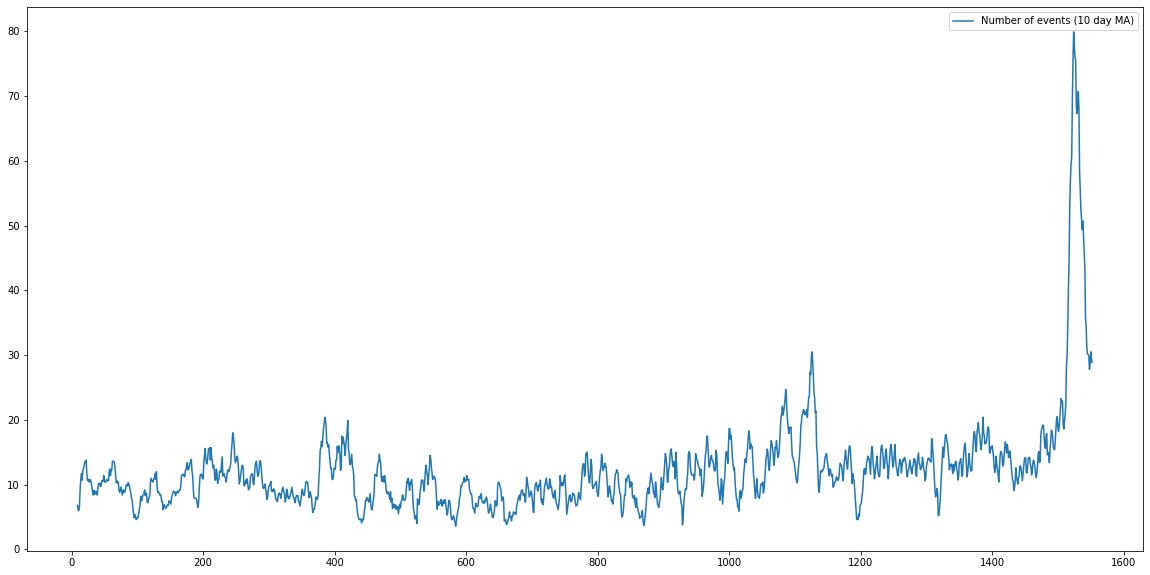

In [28]:
plt.figure(figsize=(20,10))
plt.plot(data['Number of events'].rolling(10).mean(), label='Number of events (10 day MA)')
plt.legend()

In [29]:
def calculateN0(df, sigma, deltaT):
    return df['Number of events'].rolling(window=deltaT, win_type="gaussian", center=True).mean(std=sigma)
    # N0 is Null for the first and last deltaT/2 values

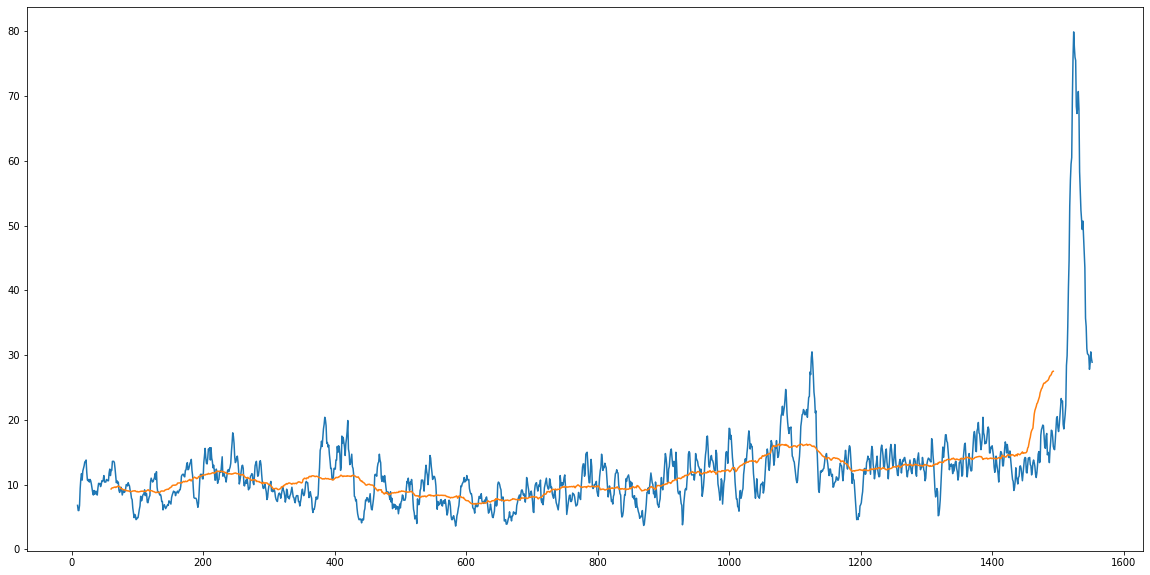

In [30]:
plt.figure(figsize=(20,10))
plt.plot(data['Number of events'].rolling(10).mean(), label='data')
plt.plot(calculateN0(data, 360, 120), label='baseline')


In [31]:
# Define a function to create a new dataframe to be used in simulation

def createSimulationDF(df, sigma, deltaT):
    data1 = df.copy()
    data1['N0'] = calculateN0(data1, sigma, deltaT)
    data1['simulated'] = 0
    data1 = data1[int(deltaT/2):int(-deltaT/2-1)]
    data1['simulated'][int(deltaT/2)] = 1
    return data1

def createSimulationDF2(df, n):
    data1 = df.copy()
    data1['N0'] = n
    data1['simulated'] = 0
    return data1

def createSimulationDF3(df, n):
    data1 = df.copy()
    data1['N0'] = (data1['Number of events'].rolling(window=120, win_type="gaussian", center=True).mean(std=360))-n
    data1 = data1[int(120/2):int(-120/2-1)]
    data1['simulated'] = 0
    return data1

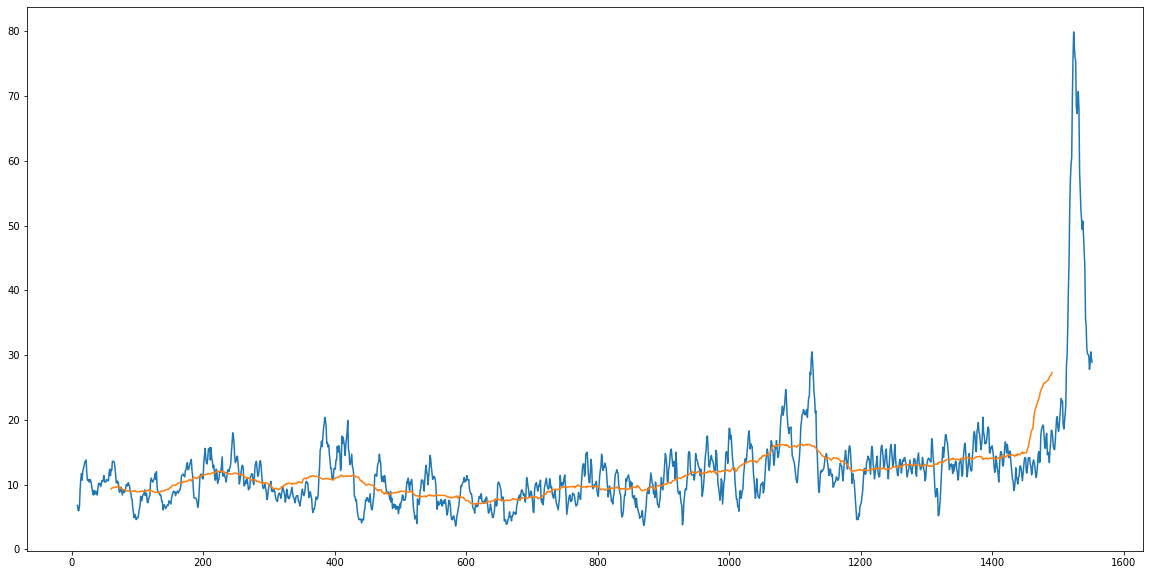

In [32]:
createSimulationDF(data, 360, 120)
plt.figure(figsize=(20,10))
plt.plot(data['Number of events'].rolling(10).mean(), label='data')
plt.plot(createSimulationDF(data, 360, 120)['N0'], label='baseline')

In [33]:
createSimulationDF(data, 360, 120).head()

,Event start date,Number of events,Number of protesters,N0,simulated
60,60,15.0,197.0,9.328223,1
61,61,10.0,317.0,9.451891,0
62,62,20.0,946.0,9.509561,0
63,63,11.0,1388.0,9.517681,0
64,64,7.0,383.0,9.567047,0


In [34]:
# Define helper function to create simulated data

def simulaterHelper(x, args):
    arr = x[-1]
    d = -x[:-1,0] + arr[0]
    psum = x[:-1,1] * (np.exp((-(d-1))/args[0][1]) - np.exp(-d/args[0][1]))
    # arr[4] = np.random.poisson(arr[3] + args[0][0]*psum.sum(), 1)[0]
    # if arr[4] == 0:
    #     arr[4] = 1
    arr[4] = arr[3] + args[0][0]*psum.sum()
    # arr[4] = psum.sum()
    # arr[4] = d[-1]
    return arr

In [35]:
def simulate(df, Nsec, Texcite):
    simulated_data = df.expanding(method="table").apply(simulaterHelper, Nsec, Texcite, raw=True, engine="numba")
    # simulated_data['Event start date'] = pd.to_datetime(simulated_data['Event start date'])
    return simulated_data

In [36]:
# Loss and error functions
def computeLoss(model, actual):
    return (model - (actual * np.log(model))).sum()

In [37]:
def functionToMinimize(x):
    sim = simulate(simulationDF, x[0], x[1])
    return computeLoss(sim['simulated'].astype(np.longdouble), sim['Number of events'].astype(np.longdouble))

In [14]:
simulationDF = createSimulationDF(data, 360, 120)
res = brute(functionToMinimize, (slice(0.01, 0.5, 0.01), slice(0.1, 15, 1)), finish=None)
print(res)

[0.06 0.1 ]


/Users/lucaswebb/pandas/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


-26671.602871525276
-22887.66896251999
-22922.435177165586


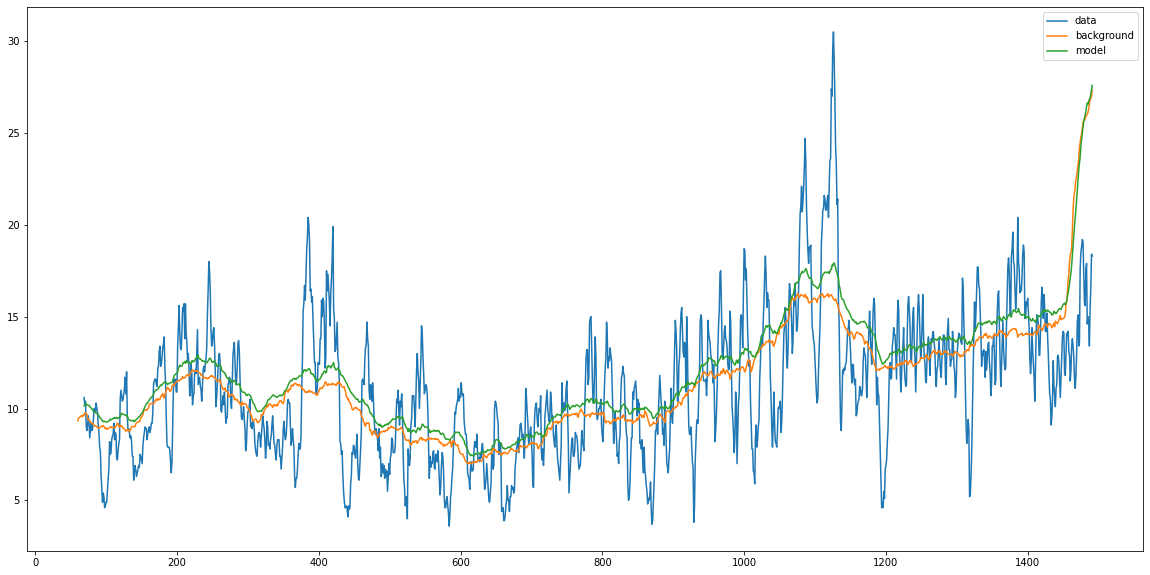

In [15]:
simulated = simulate(simulationDF, res[0], res[1])

plt.figure(figsize=(20,10))
plt.plot(simulated['Number of events'].rolling(10).mean(), label='data')
plt.plot(simulated['N0'], label='background')
plt.plot(simulated['simulated'].rolling(10).mean(), label='model')
plt.legend()

print(computeLoss(simulated['Number of events'], simulated['Number of events']))
print(computeLoss(simulated['N0'], simulated['Number of events']))
print(computeLoss(simulated['simulated'], simulated['Number of events']))


In [16]:
data['Number of events'].mean()

12.249195106245976

In [64]:
# Constant background

simulationDF = createSimulationDF2(data, 12.25)
res = brute(functionToMinimize, (slice(0.1, 1, 0.1), slice(1, 15, 1)), finish=None)
print(res)

#0.2, 1

[0.2 1. ]


-34676.684721428916
-28638.369899374775
-29240.082710563438
1203.4256223773264


Text(300, 80, 'Nsec: 0.2\nTexcite: 1.0\nLikelihood Ratio: 1203.4')

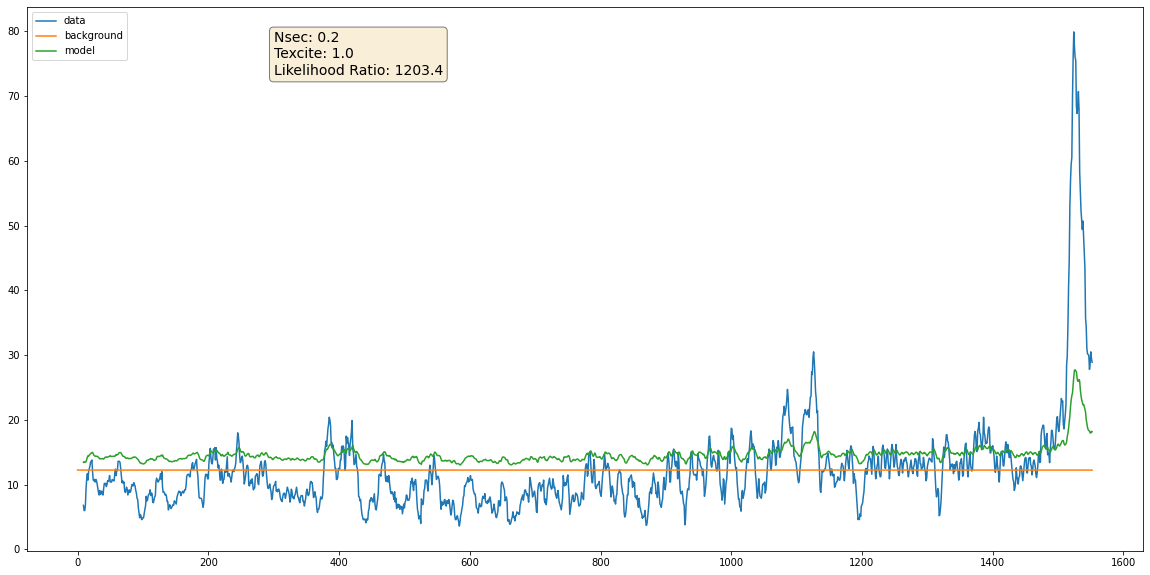

In [67]:
simulated = simulate(simulationDF, res[0], res[1])

plt.figure(figsize=(20,10))
plt.plot(simulated['Number of events'].rolling(10).mean(), label='data')
plt.plot(simulated['N0'], label='background')
plt.plot(simulated['simulated'].rolling(10).mean(), label='model')
plt.legend()

print(computeLoss(simulated['Number of events'], simulated['Number of events']))
print(computeLoss(simulated['N0'], simulated['Number of events']))
print(computeLoss(simulated['simulated'], simulated['Number of events']))
print(calculateLR(computeLoss(simulated['N0'], simulated['Number of events']), computeLoss(simulated['simulated'], simulated['Number of events'])))

textstr = '\n'.join((
    r'Nsec: %.1f' % (0.2, ),
    r'Texcite: %.1f' % (1, ),
    r'Likelihood Ratio: %.1f' % (calculateLR(computeLoss(simulated['N0'], simulated['Number of events']), computeLoss(simulated['simulated'], simulated['Number of events'])) )))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(300, 80, textstr, fontsize=14,
     verticalalignment='top', bbox=props)


In [38]:
# Look at three variable model with gaussian kernel background - constant

def functionToMinimize3(x):
    simulationDF2 = createSimulationDF3(data, x[2])
    sim = simulate(simulationDF2, x[0], x[1])
    return computeLoss(sim['simulated'].astype(np.longdouble), sim['Number of events'].astype(np.longdouble))

In [20]:
res = brute(functionToMinimize3, (slice(0.01, 0.2, 0.01), slice(0.01, 1, 0.01), slice(0, 3, 0.5)), finish=None)
print(res)

KeyboardInterrupt: 

/Users/lucaswebb/pandas/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


-26671.602871525276
-22887.66896251999
-23040.97726312132


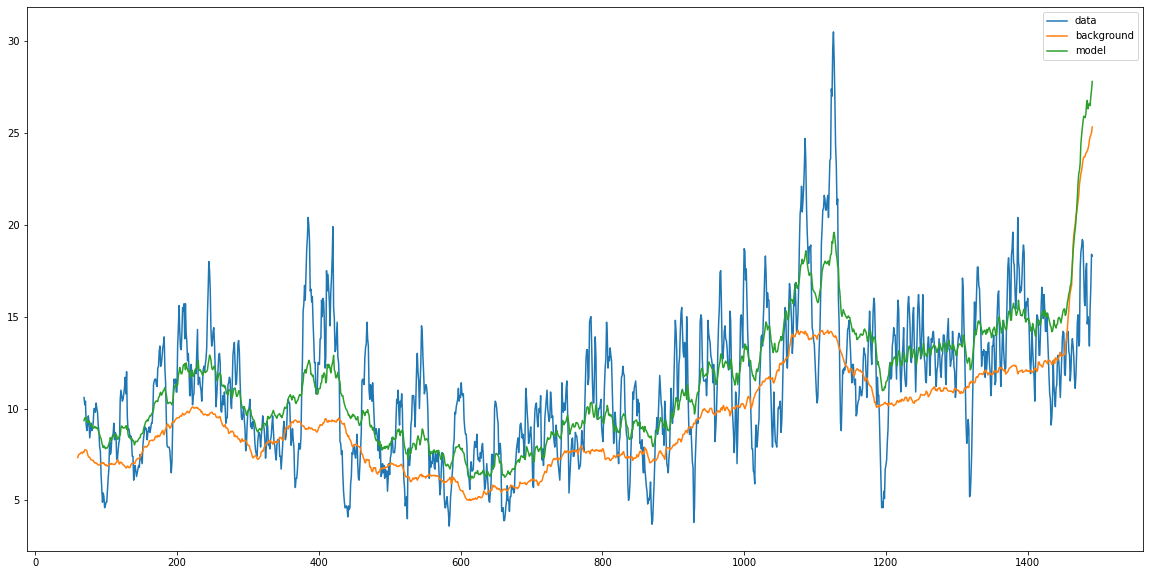

In [345]:
simulationDF2 = createSimulationDF3(data, res[2])
simulated = simulate(simulationDF2, res[0], res[1])

plt.figure(figsize=(20,10))
plt.plot(simulated['Number of events'].rolling(10).mean(), label='data')
plt.plot(simulated['N0'], label='background')
plt.plot(simulated['simulated'].rolling(10).mean(), label='model')
plt.legend()

print(computeLoss(simulated['Number of events'], simulated['Number of events']))
print(computeLoss(createSimulationDF3(data, 0)['N0'], simulated['Number of events']))
print(computeLoss(simulated['simulated'], simulated['Number of events']))

In [39]:
# Try the approach of the Irag paper with a scaling factor for background and contagious

def simulaterHelper2(x, args):
    arr = x[-1]
    d = -x[:-1,0] + arr[0]
    psum = x[:-1,1] * (np.exp((-(d-1))/args[0][1]) - np.exp(-d/args[0][1]))
    arr[4] = arr[3]*args[0][2] + args[0][0]*(psum.sum())
    # arr[4] = psum[0]
    # arr[4] = d[-1]
    return arr

In [40]:
def simulate2(df, Nsec, Texcite, p):
    simulated_data = df.expanding(method="table").apply(simulaterHelper2, Nsec, Texcite, p, raw=True, engine="numba")
    return simulated_data

In [41]:
def functionToMinimize2(x):
    sim = simulate2(simulationDF, x[0], x[1], x[2])
    return computeLoss(sim['simulated'].astype(np.longdouble), sim['Number of events'].astype(np.longdouble))

In [71]:
simulationDF = createSimulationDF(data, 360, 120)
res = brute(functionToMinimize2, (slice(0.1, 1, 0.1), slice(1, 15, 1), slice(0, 1, 0.1)), finish=None)
print(res)

/Users/lucaswebb/pandas/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


[0.3 1.  0.7]


-26671.602871525276
-22887.66896251999
-23033.125799578145


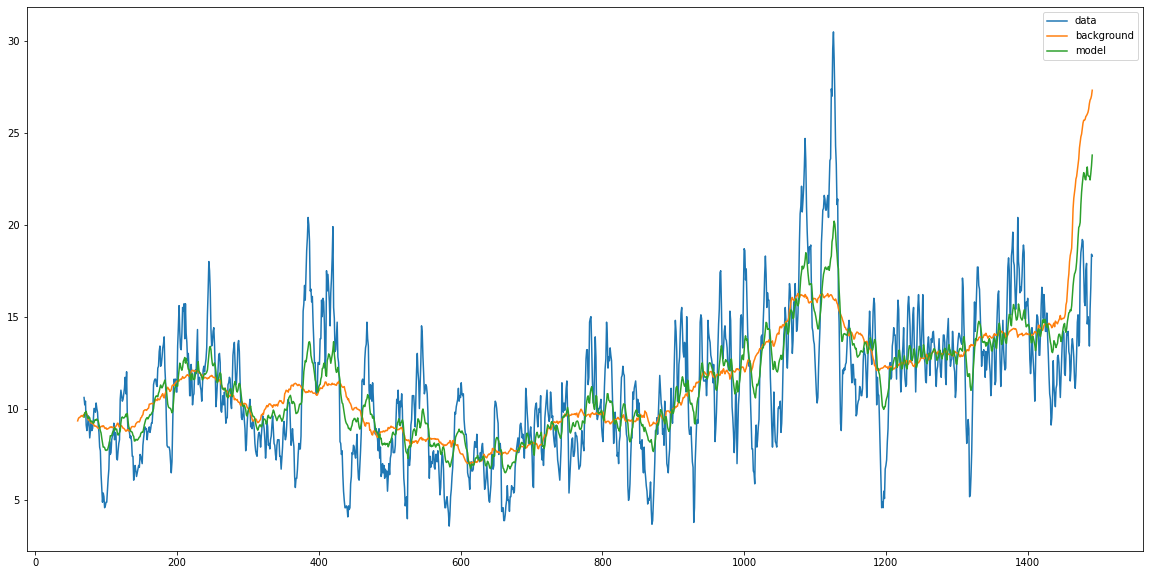

In [25]:
simulated = simulate2(simulationDF, res[0], res[1], res[2])

plt.figure(figsize=(20,10))
plt.plot(simulated['Number of events'].rolling(10).mean(), label='data')
plt.plot(simulated['N0'], label='background')
plt.plot(simulated['simulated'].rolling(10).mean(), label='model')
plt.legend()

print(computeLoss(simulated['Number of events'], simulated['Number of events']))
print(computeLoss(simulated['N0'], simulated['Number of events']))
print(computeLoss(simulated['simulated'], simulated['Number of events']))
print(calculateLR(computeLoss(simulated['N0'], simulated['Number of events']), computeLoss(simulated['simulated'], simulated['Number of events'])))

textstr = '\n'.join((
    r'Nsec: %.1f' % (0.3, ),
    r'Texcite: %.1f' % (1, ),
    r'p: %.1f' % (1, ),
    r'Likelihood Ratio: %.1f' % (calculateLR(computeLoss(simulated['N0'], simulated['Number of events']), computeLoss(simulated['simulated'], simulated['Number of events'])) )))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(300, 80, textstr, fontsize=14,
         verticalalignment='top', bbox=props)

/Users/lucaswebb/pandas/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


-26671.602871525276
-22887.66896251999
-22568.73366223931


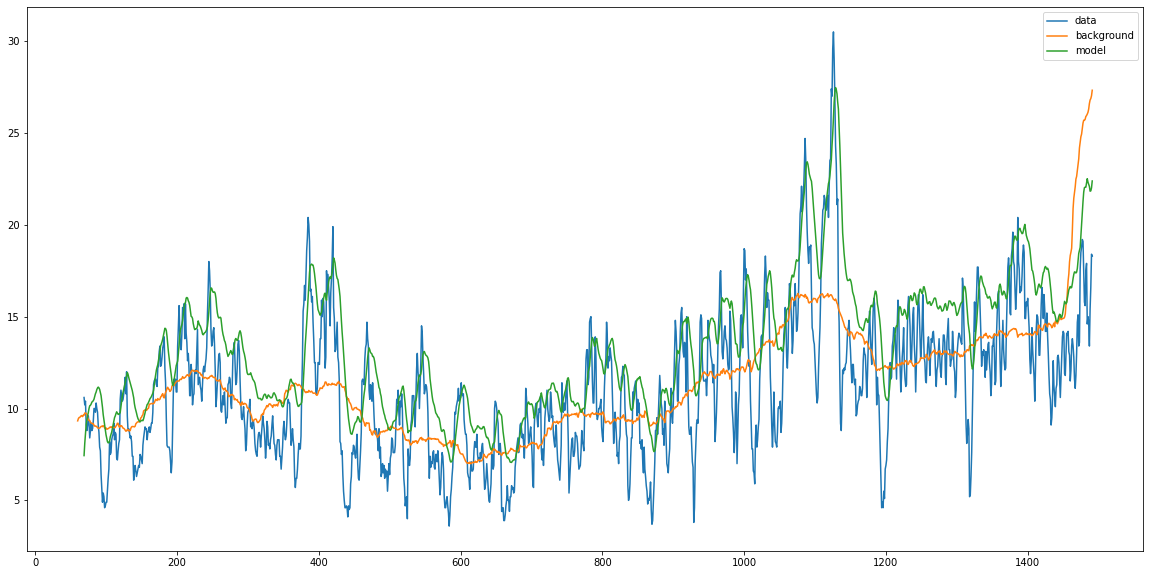

In [26]:
simulated = simulate2(simulationDF, 0.9, 7, 0.3)

plt.figure(figsize=(20,10))
plt.plot(simulated['Number of events'].rolling(10).mean(), label='data')
plt.plot(simulated['N0'], label='background')
plt.plot(simulated['simulated'].rolling(10).mean(), label='model')
plt.legend()

print(computeLoss(simulated['Number of events'], simulated['Number of events']))
print(computeLoss(simulated['N0'], simulated['Number of events']))
print(computeLoss(simulated['simulated'], simulated['Number of events']))

In [27]:
simulated.head()

,Event start date,Number of events,Number of protesters,N0,simulated
60,60.0,15.0,197.0,9.328223,2.798467
61,61.0,10.0,317.0,9.451891,4.632716
62,62.0,20.0,946.0,9.509561,5.608875
63,63.0,11.0,1388.0,9.517681,7.640624
64,64.0,7.0,383.0,9.567047,8.336311


In [42]:
# Whole country constant baseline 3 param

data['Number of events'].mean()

12.249195106245976

In [43]:
# Constant background

simulationDF = createSimulationDF2(data, 12.25)
res = brute(functionToMinimize2, (slice(0.1, 1, 0.1), slice(1, 15, 1), slice(0, 1, 0.1)), finish=None)
print(res)

/Users/lucaswebb/pandas/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


KeyboardInterrupt: 

-34676.684721428916
-28638.369899374775
-30366.16501226782
3455.590225786087


Text(300, 80, 'Nsec: 0.8\nTexcite: 5.0\np: 0.2\nLikelihood Ratio: 3455.6')

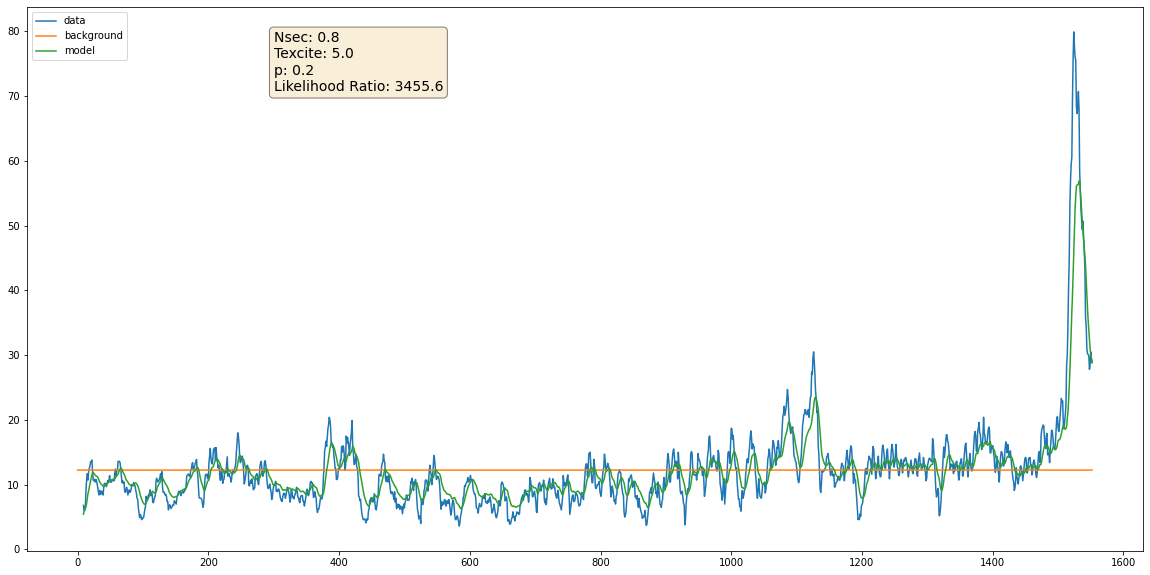

In [74]:
simulated = simulate2(simulationDF, res[0], res[1], res[2])

plt.figure(figsize=(20,10))
plt.plot(simulated['Number of events'].rolling(10).mean(), label='data')
plt.plot(simulated['N0'], label='background')
plt.plot(simulated['simulated'].rolling(10).mean(), label='model')
plt.legend()

print(computeLoss(simulated['Number of events'], simulated['Number of events']))
print(computeLoss(simulated['N0'], simulated['Number of events']))
print(computeLoss(simulated['simulated'], simulated['Number of events']))
print(calculateLR(computeLoss(simulated['N0'], simulated['Number of events']), computeLoss(simulated['simulated'], simulated['Number of events'])))

textstr = '\n'.join((
    r'Nsec: %.1f' % (0.8, ),
    r'Texcite: %.1f' % (5, ),
    r'p: %.1f' % (0.2, ),
    r'Likelihood Ratio: %.1f' % (calculateLR(computeLoss(simulated['N0'], simulated['Number of events']), computeLoss(simulated['simulated'], simulated['Number of events'])) )))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(300, 80, textstr, fontsize=14,
         verticalalignment='top', bbox=props)

In [44]:
# 3 param constant background whole country whole time-frame with skopt
simulationDF = createSimulationDF2(data, 12.25)
res = gp_minimize(functionToMinimize2, [(0.0, 1.0), (0.0001, 20.0), (0.0, 1)], n_calls=40, noise=1e-10, n_initial_points=10, random_state=123)
print(res.x)


/Users/lucaswebb/pandas/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


ValueError: Input contains NaN, infinity or a value too large for dtype('float128').

In [ ]:

# Train on first half
simulationDF = createSimulationDF2(data.loc[:750], 12.25)
res = brute(functionToMinimize2, (slice(0.1, 1, 0.1), slice(1, 15, 1), slice(0, 1, 0.1)), finish=None)
print(res)

In [32]:
# Test on second half
simulated = simulate2(createSimulationDF2(data.loc[750:], 12.25), res[0], res[1], res[2])

print(computeLoss(simulated['Number of events'], simulated['Number of events']))
print(computeLoss(simulated['N0'], simulated['Number of events']))
print(computeLoss(simulated['simulated'], simulated['Number of events']))

-24100.669125560085
-19936.414709260916
-21119.039143962393


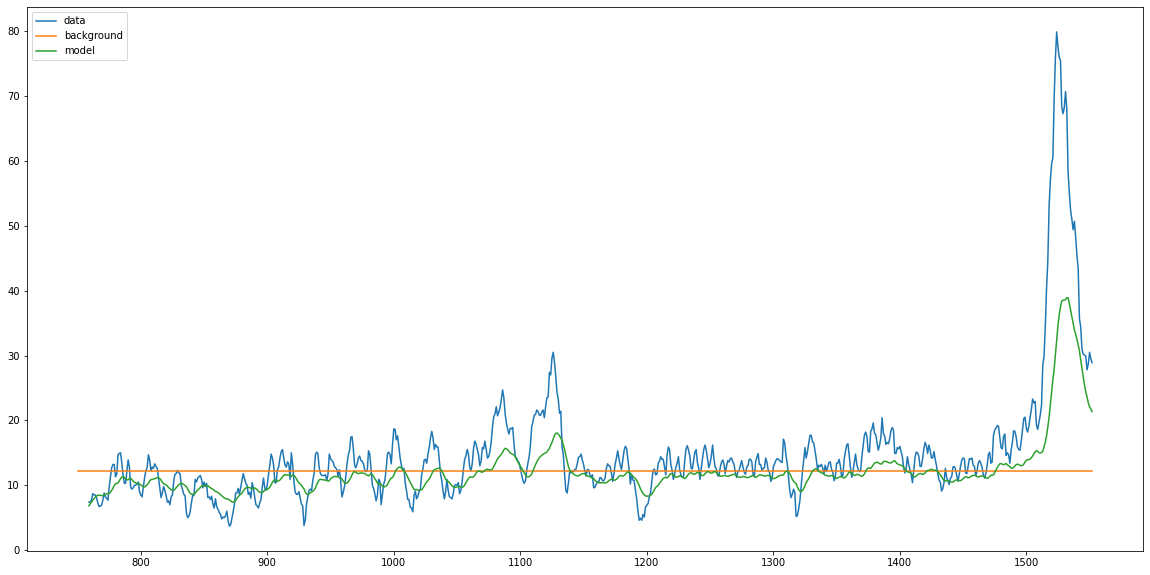

In [33]:
plt.figure(figsize=(20,10))
plt.plot(simulated['Number of events'].rolling(10).mean(), label='data')
plt.plot(simulated['N0'], label='background')
plt.plot(simulated['simulated'].rolling(10).mean(), label='model')
plt.legend()

In [34]:
def calculateLR(null, sim):
    return 2 * (null - sim)

In [37]:
print(calculateLR(-28638.369899374775, -30366.16501226782))
print(calculateLR(-28638.369899374775, -28600.369899374775))

3455.590225786087
-76.0
